# Sensor-level RSA example on the kiloword EEG dataset

This example demonstrates how to perform representational similarity analysis (RSA) on EEG data, using a searchlight approach.

In the searchlight approach, representational similarity is computed between the model and searchlight "patches". A patch is defined by a seed point (e.g. sensor Pz) and everything within the given radius (e.g. all sensors within 4 cm. of Pz). Patches are created for all possible seed points (e.g. all sensors), so you can think of it as a "searchlight" that moves from seed point to seed point and everything that is in the spotlight is used in the computation.

The radius of a searchlight can be defined in space, in time, or both. In this example, our searchlight will have a spatial radius of 4.5 cm. and a temporal radius of 50 ms.

The dataset will be the kiloword dataset [1]: approximately 1,000 words were presented to 75 participants in a go/no-go lexical decision task while event-related potentials (ERPs) were recorded.

[1] Dufau, S., Grainger, J., Midgley, KJ., Holcomb, PJ. A thousand words are worth a picture: Snapshots of printed-word processing in an event-related potential megastudy. Psychological science, 2015

In [5]:
# Import required packages
import mne
import mne_rsa

# Configure the graphics engine: figures should be embedded in this notebook
%matplotlib inline

MNE-Python contains a build-in data loader for the kiloword dataset. We use it here to read it as 960 epochs. Each epoch represents the brain response to a single word, averaged across all the participants. For this example, we speed up the computation, at a cost of temporal precision, by downsampling the data from the original 250 Hz. to 100 Hz. 

In [6]:
data_path = mne.datasets.kiloword.data_path(verbose=True)
epochs = mne.read_epochs(data_path + '/kword_metadata-epo.fif')
epochs = epochs.resample(100)

Reading C:\Users\wmvan\mne_data\MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
960 matching events found
No baseline correction applied
Adding metadata with 8 columns
0 projection items activated


The `epochs` object contains a `.metadata` field that contains information about the 960 words that were used in the experiment. Let's have a look at the metadata for the 10 random words:

In [7]:
epochs.metadata.sample(10)

,WORD,Concreteness,WordFrequency,OrthographicDistance,NumberOfLetters,BigramFrequency,ConsonantVowelProportion,VisualComplexity
798,squad,4.550000,2.225309,1.70,5.0,156.200000,0.600000,75.786439
956,reversal,3.700000,1.991226,2.65,8.0,859.000000,0.625000,60.545879
262,poem,4.450000,2.414973,1.85,4.0,298.000000,0.500000,82.239855
648,horizon,4.950000,2.515874,2.90,7.0,521.428571,0.571429,60.077749
885,concept,2.150000,2.930440,1.95,7.0,900.285714,0.714286,67.052144
704,graduate,4.850000,2.093422,2.65,8.0,630.375000,0.500000,70.751988
520,hunk,4.388889,1.531479,1.25,4.0,284.250000,0.750000,66.655696
274,crew,4.850000,2.583199,1.65,4.0,566.500000,0.750000,71.259695
734,camp,5.350000,3.030600,1.20,4.0,656.500000,0.750000,79.461521
820,report,5.150000,3.269746,1.75,6.0,718.666667,0.666667,60.874401


Let's pick something obvious for this example and build a dissimilarity matrix (DSM) based on the number of letters in each word.

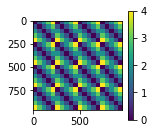

In [8]:
dsm_vis = mne_rsa.compute_dsm(epochs.metadata[['NumberOfLetters']], metric='euclidean')
mne_rsa.plot_dsms(dsm_vis);

The above DSM will serve as our "model" DSM. In this example RSA analysis, we are going to compare the model DSM against DSMs created from the EEG data. The EEG DSMs will be created using a "searchlight" pattern. We are using squared Euclidean distance for our DSM metric, since we only have a few data points in each searlight patch. Feel free to play around with other metrics.

In [ ]:
rsa_result = mne_rsa.rsa_epochs(epochs,      # The EEG data
                                dsm_vis,     # The model DSM
                                epochs_dsm_metric='sqeuclidean',  # Metric to use to compute the EEG DSMs
                                rsa_metric='kendall-tau-a',   # Metric to use to compare the model and EEG DSMs
                                spatial_radius=45,  # Spatial radius of the searchlight patch
                                temporal_radius=0.05,   # Temporal radius of the searchlight path
                                tmin=0.15, tmax=0.25,  # To save time, only analyze this time interval
                                n_jobs=1,  # Only use one CPU core. Increase this for more speed.
                                verbose=True)  # Print progress bar

The result is packed inside an MNE-Python [`Evoked`](https://mne.tools/stable/generated/mne.Evoked.html) object. This object defines many plotting functions, for example `plot_topomap` to look at the spatial distribution of the RSA values. By default, the signal is assumed to represent micro-Volts, so we need to explicitly inform the plotting function we are plotting RSA values and tweak the range of the colormap.

In [ ]:
rsa_result.plot_topomap(rsa_result.times, units=dict(eeg='kendall-tau-a'), scalings=dict(eeg=1),
                        cbar_fmt='%.4f', vmin=0);

In [9]:
data_dsms = mne_rsa.dsm_epochs(epochs, dist_metric='sqeuclidean', spatial_radius=45, temporal_radius=0.05, tmin=0.15, tmax=0.25)
rsa_result = mne_rsa.rsa(data_dsms, dsm_vis, metric='kendall-tau-a', n_jobs=6, n_data_dsms=319, verbose=True)

unsurprisingly, we get the highest correspondance between number of letters and EEG signal in areas in the visual cortex.